# Tutorial 6: Inspecting predicted proteome allocation

In this tutorial we will calculate the proteome allocation predicted by the _Bacillus subtilis_ ME-model.

## Import libraries

In [1]:
from coralme.builder.main import MEBuilder
from coralme.util.flux_analysis import flux_based_reactions
import coralme
import pandas
import tqdm

## Load

Load the ME-model coming out of the Troubleshooter

In [2]:
me = coralme.io.json.load_json_me_model("MEModel-step3-bsubtilis-TS.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16


Adding Metabolites into the ME-model...                                    : 100.0%|██████████|  4631/ 4631 [00:00<00:00]
Adding ProcessData into the ME-model...                                    : 100.0%|██████████|  4754/ 4754 [00:00<00:00]
Adding Reactions into the ME-model...                                      : 100.0%|██████████|  7759/ 7759 [00:17<00:00]
Updating ME-model Reactions...                                             : 100.0%|██████████|  6328/ 6328 [00:18<00:00]


## Solve

In [3]:
me.optimize()

The MINOS and quad MINOS solvers are a courtesy of Prof Michael A. Saunders. Please cite Ma, D., Yang, L., Fleming, R. et al. Reliable and efficient solution of genome-scale models of Metabolism and macromolecular Expression. Sci Rep 7, 40863 (2017). https://doi.org/10.1038/srep40863

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	1.4050280687025918	Not feasible
        2	0.7025140343512959	Not feasible
        3	0.3512570171756479	Not feasible
        4	0.1756285085878240	Optimal
        5	0.2634427628817360	Not feasible
        6	0.2195356357347800	Not feasible
        7	0.1975820721613020	Not feasible
        8	0.1866052903745630	Not feasible
        9	0.1811168994811935	Not feasible
       10	0.1783727040345087	Not feasible
       11	0.1770006063111663	Not feasible
       12	0.1763145574494951	Optimal
       13	0.1766575818803308	Optimal
       14	0.1768290940957485	Optimal
       15	0.1769148502034574	Not feasible
       16	0.176871

True

## Proteome allocation

We here use some of the functions provided in coralME to calculate proteome allocation. This part of the analysis can take several minutes to run. The algorithm needs to traverse the ME-network finding where all proteins go (accounting for final destinations only) and calculate the partitioning from the fluxes.

### Calculate protein to complex partitioning

Here we calculate the final complexes to which 1 unit of every protein goes

In [4]:
from coralme.builder.helper_functions import get_partitioning,get_immediate_partitioning

In [5]:
ComplexPartitioning = {}
for protein in tqdm.tqdm(me.metabolites.query("^protein_")):
    if not isinstance(protein,coralme.core.component.TranslatedGene):
        continue
    partitioning = get_partitioning(protein,seen = set(),final_fraction=1.0)
    if not partitioning:
        continue
    ComplexPartitioning[protein.id] = {k.id:v for k,v in partitioning}

100%|██████████| 1350/1350 [06:29<00:00,  3.47it/s]


In [6]:
pandas.DataFrame.from_dict(ComplexPartitioning).fillna(0.).head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40420,protein_BSU40500,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy
BSU00090-MONOMER,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CPLX8J2-131,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU00130-MONOMER,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU00140-MONOMER,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU00150-MONOMER,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate protein to function partitioning

Here we calculate the final reactions to which 1 unit of every protein goes

In [7]:
ReactionPartitioning = {}
for protein,partitioning in tqdm.tqdm(ComplexPartitioning.items()):
    ReactionPartitioning[protein] = {}
    tmp = pandas.Series()
    for k,fraction in partitioning.items():
        ip = {k.id:v for k,v in get_immediate_partitioning(me.get(k)).items()}
        tmp = tmp.append(pandas.Series(ip) * fraction)
        if tmp.duplicated().any():
            tmp = tmp.to_frame().reset_index().groupby("index").sum()[0]
    ReactionPartitioning[protein] = tmp.to_dict()

100%|██████████| 495/495 [06:28<00:00,  1.28it/s]


In [8]:
ReactionPartitioning = pandas.DataFrame.from_dict(ReactionPartitioning).fillna(0.)
ReactionPartitioning.head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40420,protein_BSU40500,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy
IMPD_FWD_BSU00090-MONOMER,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PYRIS_FWD_CPLX8J2-131,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_63_UCU,0.0,0.0,0.0,0.194926,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_7_UCG,0.0,0.0,0.0,0.138799,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_30_AGC,0.0,0.0,0.0,0.131409,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get reaction to class dictionary

Here we classify all reactions into categories to simplify the analysis

In [9]:
def get_function(r,metabolics=False):
    if isinstance(r,coralme.core.reaction.MetabolicReaction) and hasattr(r,'subsystem'):
        if r.subsystem and metabolics:
            return 'Metabolic:' + r.subsystem
        return 'Metabolic'
    if isinstance(r,coralme.core.reaction.TranslationReaction):
        return 'Translation'
    elif isinstance(r,coralme.core.reaction.TranscriptionReaction):
        return 'Transcription'
    elif isinstance(r,coralme.core.reaction.tRNAChargingReaction):
        return 'tRNA-Charging'
    elif isinstance(r,coralme.core.reaction.PostTranslationReaction):
        return 'Post-translation'
    elif isinstance(r,coralme.core.reaction.SummaryVariable):
        return 'Biomass'
    return "No_function"

In [10]:
ReactionToClass = pandas.DataFrame(index=[r.id for r in me.reactions]).reset_index()
ReactionToClass["Function1"] = ReactionToClass["index"].apply(lambda x:get_function(me.get(x)))
ReactionToClass["Function2"] = ReactionToClass["index"].apply(lambda x:get_function(me.get(x),metabolics=True))
ReactionToClass = ReactionToClass.set_index("index")
ReactionToClass.head()

,Function1,Function2
index,,
biomass_dilution,Biomass,Biomass
BSU15140-MONOMER_to_generic_16Sm4Cm1402,No_function,No_function
RNA_BSU_rRNA_1_to_generic_16s_rRNAs,No_function,No_function
RNA_BSU_rRNA_16_to_generic_16s_rRNAs,No_function,No_function
RNA_BSU_rRNA_19_to_generic_16s_rRNAs,No_function,No_function


### Get protein translation fluxes

In [11]:
dct = {}
for r in me.query("translation_"):
    p = "protein_" + r.id.split("translation_")[1]
    dct[p] = r.flux * me.get(p).formula_weight/1000
TranslationFluxes = pandas.Series(dct)
TranslationFluxes.head()

protein_BSU00090    2.301524e-06
protein_BSU00110    1.053056e-10
protein_BSU00120    7.172958e-11
protein_BSU00130    3.400413e-06
protein_BSU00140    4.820446e-09
dtype: float64

### Combine results into one dataframe

Now we calculate the contributions of all proteins to every reaction flux

In [12]:
FluxPartitioning = (ReactionPartitioning*TranslationFluxes).dropna(axis=1)
FluxPartitioning.head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40420,protein_BSU40500,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy
IMPD_FWD_BSU00090-MONOMER,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PYRIS_FWD_CPLX8J2-131,0.000000,1.053056e-10,7.172958e-11,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_63_UCU,0.000000,0.000000e+00,0.000000e+00,6.628296e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_7_UCG,0.000000,0.000000e+00,0.000000e+00,4.719729e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charging_tRNA_BSU_tRNA_30_AGC,0.000000,0.000000e+00,0.000000e+00,4.468459e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The sum of all fluxes should add up to the protein biomass

In [13]:
FluxPartitioning.sum().sum()

0.06018928390435255

In [14]:
me.solution.fluxes["protein_biomass_to_biomass"]

0.06019028617239898

### Visualize proteome allocation

Now we annotate it for further analysis

In [15]:
AnnotatedFluxPartitioning = pandas.concat([FluxPartitioning,ReactionToClass],axis=1).dropna(axis=0)
AnnotatedFluxPartitioning.head()

,protein_BSU00090,protein_BSU00110,protein_BSU00120,protein_BSU00130,protein_BSU00140,protein_BSU00150,protein_BSU00180,protein_BSU00280,protein_BSU00380,protein_BSU00410,...,protein_BSU40550,protein_BSU40890,protein_BSU40910,protein_BSU41000,protein_BSU41040,protein_BSU41050,protein_BSU41060,protein_dummy,Function1,Function2
IMPD_FWD_BSU00090-MONOMER,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic:S_Nucleotides_and_nucleic_acids
PYRIS_FWD_CPLX8J2-131,0.000000,1.053056e-10,7.172958e-11,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic:S_Coenzymes_and_prosthetic_groups
charging_tRNA_BSU_tRNA_63_UCU,0.000000,0.000000e+00,0.000000e+00,6.628296e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tRNA-Charging,tRNA-Charging
charging_tRNA_BSU_tRNA_7_UCG,0.000000,0.000000e+00,0.000000e+00,4.719729e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tRNA-Charging,tRNA-Charging
charging_tRNA_BSU_tRNA_30_AGC,0.000000,0.000000e+00,0.000000e+00,4.468459e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tRNA-Charging,tRNA-Charging


<Axes: >

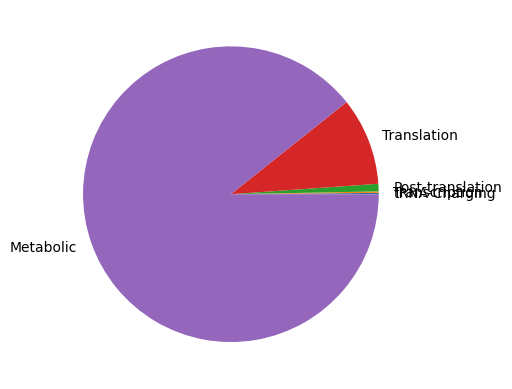

In [17]:
AnnotatedFluxPartitioning.groupby("Function1").sum().sum(axis=1).sort_values().plot.pie()

<Axes: >

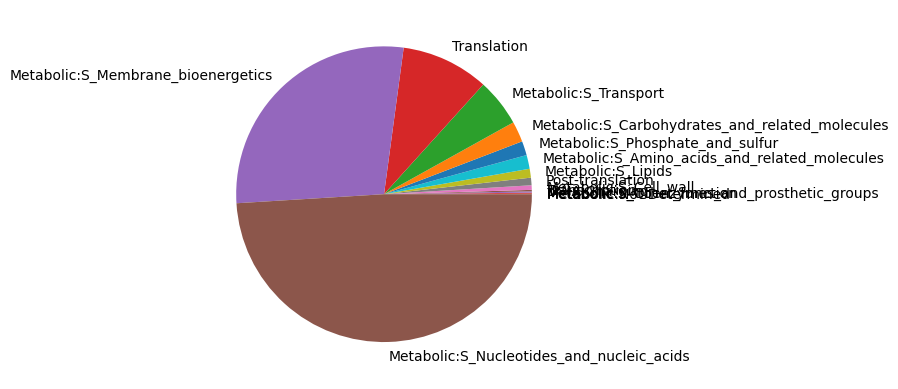

In [18]:
AnnotatedFluxPartitioning.groupby("Function2").sum().sum(axis=1).sort_values().plot.pie()